<a href="https://colab.research.google.com/github/adasrinivas1229/MYPROJECTS/blob/master/CGANFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For the 'InstanceNormalization' layer
!pip install --upgrade tensorflow_addons
# For the dataset
!pip install --upgrade tensorflow_datasets

     |████████████████████████████████| 1.1MB 3.4MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3
     |████████████████████████████████| 3.4MB 3.1MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import (Activation, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization

import tensorflow_datasets as tfds

%matplotlib inline

In [3]:
# Load dataset
data, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)

train_x, train_y, test_x, test_y = data['trainA'], data['trainB'], data['testA'], data['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteMEA6QM/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteMEA6QM/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteMEA6QM/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteMEA6QM/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


In [4]:
# Settings
epochs = 50

LAMBDA = 10

img_rows, img_cols, channels = 256, 256, 3
weight_initializer = RandomNormal(stddev=0.02)

gen_g_optimizer = gen_f_optimizer = Adam(lr=0.0002, beta_1=0.5)
dis_x_optimizer = dis_y_optimizer = Adam(lr=0.0002, beta_1=0.5)

In [5]:
# Normalize images to [-1, 1] and reshape
def preprocess_image(image, _):
    return tf.reshape(tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1, (1, img_rows, img_cols, channels))

In [6]:
# Map the normalization onto the dataset
train_x = train_x.map(preprocess_image)
train_y = train_y.map(preprocess_image)
test_x = test_x.map(preprocess_image)
test_y = test_y.map(preprocess_image)

In [7]:
# "Ck denotes a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2
def Ck(input, k, use_instancenorm=True):
    block = Conv2D(k, (4, 4), strides=2, padding='same', kernel_initializer=weight_initializer)(input)
    if use_instancenorm:
        block = InstanceNormalization(axis=-1)(block)
    block = LeakyReLU(0.2)(block)

    return block

# C64, C128, C256, C512
def discriminator():
    dis_input = Input(shape=(img_rows, img_cols, channels))

    d = Ck(dis_input, 64, False)
    d = Ck(d, 128)
    d = Ck(d, 256)
    d = Ck(d, 512)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=weight_initializer)(d)

    return Model(dis_input, d)

In [8]:
# "dk denotes a 3×3 Convolution-InstanceNorm-ReLU with k filters and stride 2"
def dk(k, use_instancenorm=True):
    block = Sequential()
    block.add(Conv2D(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
    if use_instancenorm:
        block.add(InstanceNormalization(axis=-1))
    block.add(Activation('relu'))

    return block

# "uk denotes a 3×3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride ½"
def uk(k):
    block = Sequential()
    block.add(Conv2DTranspose(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
    block.add(InstanceNormalization(axis=-1))
    block.add(Activation('relu'))

    return block

def generator():
    gen_input = Input(shape=(img_rows, img_cols, channels))
    
    # Layers for the encoder part of the model
    encoder_layers = [
        dk(64, False),
        dk(128),
        dk(256),
        dk(512),
        dk(512),
        dk(512),
        dk(512),
        dk(512)
    ]

    # Layers for the decoder part of the model
    decoder_layers = [
        uk(512),
        uk(512),
        uk(512),
        uk(512),
        uk(256),
        uk(128),
        uk(64)
    ]

    gen = gen_input

    # Add all the encoder layers, and keep track of them for skip connections
    skips = []
    for layer in encoder_layers:
        gen = layer(gen)
        skips.append(gen)
    
    skips = skips[::-1][1:] # Reverse for looping and get rid of the layer that directly connects to decoder

    # Add all the decoder layers and skip connections
    for skip_layer, layer in zip(skips, decoder_layers):
        gen = layer(gen)
        gen = Concatenate()([gen, skip_layer])

    
    # Final layer
    gen = Conv2DTranspose(channels, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer, activation='tanh')(gen)
    
    # Compose model
    return Model(gen_input, gen)

In [9]:
# Define the models
generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()

In [10]:
# Losses
loss = BinaryCrossentropy(from_logits=True)

# Measures how close to one real images are rated, and how close to zero fake images are rated
def discriminator_loss(real, generated):
    # Multiplied by 0.5 so that it will train at half-speed
    return (loss(tf.ones_like(real), real) + loss(tf.zeros_like(generated), generated)) * 0.5

# Measures how real the discriminator believes the fake image is
def gen_loss(validity):
    return loss(tf.ones_like(validity), validity)

# Measures similarity of two images.  Used for cycle and identity loss
def image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

In [11]:
@tf.function
def step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Setup Dy loss
        fake_y = generator_g(real_x, training=True)
        gen_g_validity = discriminator_y(fake_y, training=True)
        dis_y_loss = discriminator_loss(discriminator_y(real_y, training=True), gen_g_validity)

        with tape.stop_recording():
            discriminator_y_gradients = tape.gradient(dis_y_loss, discriminator_y.trainable_variables)
            dis_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

        # Setup Dx loss
        fake_x = generator_f(real_y, training=True)
        gen_f_validity = discriminator_x(fake_x, training=True)
        dis_x_loss = discriminator_loss(discriminator_x(real_x, training=True), gen_f_validity)

        with tape.stop_recording():
            discriminator_x_gradients = tape.gradient(dis_x_loss, discriminator_x.trainable_variables)
            dis_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

        # Setup adversarial losses
        gen_g_adv_loss = gen_loss(gen_g_validity)
        gen_f_adv_loss = gen_loss(gen_f_validity)

        # Setup cycle losses
        cyc_x = generator_f(fake_y, training=True)
        cyc_x_loss = image_similarity(real_x, cyc_x)

        cyc_y = generator_g(fake_x, training=True)
        cyc_y_loss =  image_similarity(real_y, cyc_y)

        # Setup identity losses
        id_x = generator_f(real_x, training=True)
        id_x_loss = image_similarity(real_x, id_x)

        id_y = generator_g(real_y, training=True)
        id_y_loss = image_similarity(real_y, id_y)

        # Finalize generator losses and calc gradients
        gen_g_loss = gen_g_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_y_loss * 0.5*LAMBDA
        gen_f_loss = gen_f_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_x_loss * 0.5*LAMBDA

        with tape.stop_recording():
            generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
            gen_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

            generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)
            gen_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

In [12]:
def generate_images():
    # Sample images
    x = next(iter(test_x.shuffle(1000))).numpy()
    y = next(iter(test_y.shuffle(1000))).numpy()
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Epoch: 0
0
100
200
300
400
500
600
700
800
900
1000


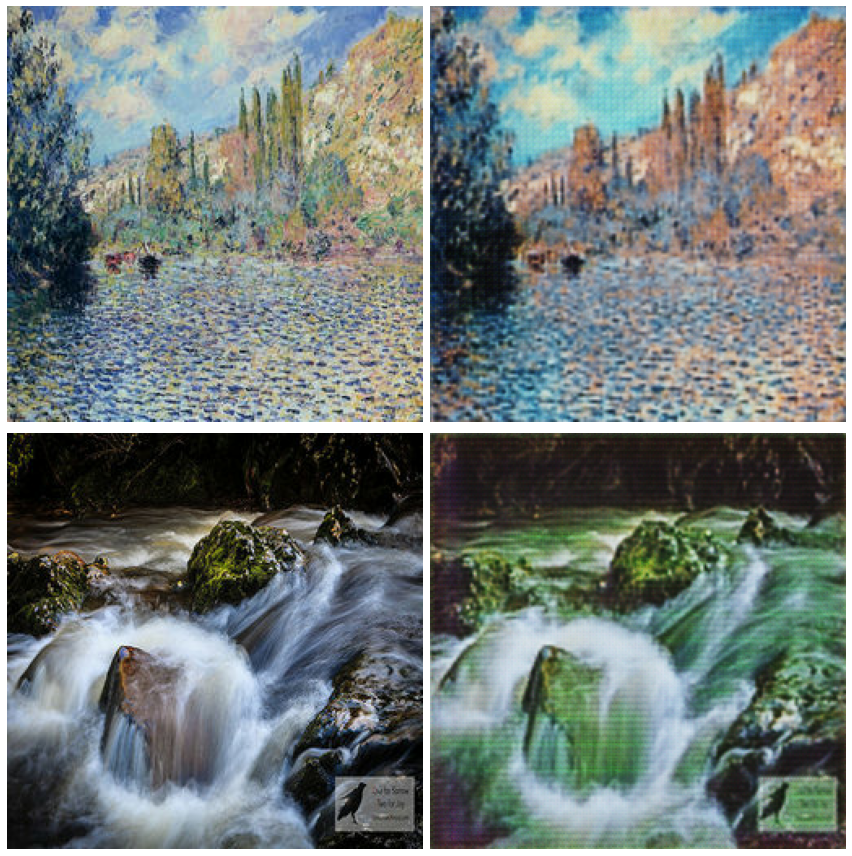

Time taken: 5255.797199487686
Epoch: 1
0
100
200
300
400


In [ ]:
# Manually loop through epochs
for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    start = time.time()

    # Each batch
    for k, (real_x, real_y) in enumerate(tf.data.Dataset.zip((train_x, train_y))):
        if k % 100 == 0: print(k)
        # Train step
        step(tf.reshape(real_x, (1, img_rows, img_cols, channels)), tf.reshape(real_y, (1, img_rows, img_cols, channels)))
    
    # View progress
    generate_images()
    print('Time taken: {}'.format(time.time() - start))